In [7]:
import tensorflow as tf
import numpy as np
from tensorflow import keras

print(tf.__version__)
print(np.__version__)

2.6.0
1.21.4


In [8]:
!nvidia-smi

Tue Nov  7 07:34:53 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.182.03   Driver Version: 470.182.03   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   69C    P0    29W /  70W |    256MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [9]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

# 1) ResNet 기본 블록 구성하기

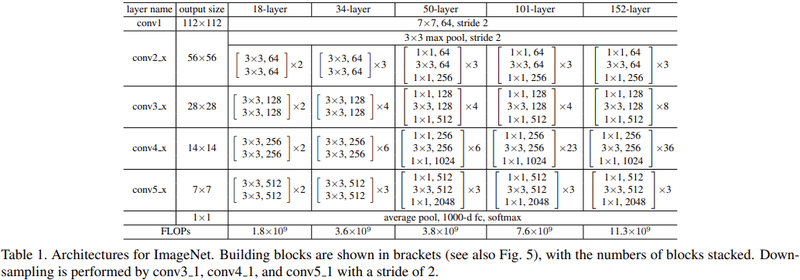

In [2]:
def residual_block(x, n_times, filters, is_50=False, use_connection=True):    
    filters_1 = filters
    filters_2 = filters * 4
    
    # 3, 4, 5번 시작할 때 Conv는 stride 2로 해줘야 됨.
    if not is_50:
        for i in range(n_times):
            shortcut = tf.keras.layers.Conv2D(filters_1, 1, 
                                              strides=2 if i==0 else 1, 
                                              activation=None, 
                                              padding='same')(x)

            x = tf.keras.layers.Conv2D(filters_1, 3, 
                                       strides=2 if i==0 else 1,
                                       activation=None, 
                                       padding='same')(x)
            
            x = tf.keras.layers.BatchNormalization()(x)
            x = tf.keras.layers.Activation("relu")(x)
            
            x = tf.keras.layers.Conv2D(filters_1, 3, activation=None, padding='same')(x)
            x = tf.keras.layers.BatchNormalization()(x)
            if use_connection:
                x = tf.keras.layers.Add()([shortcut, x])
            x = tf.keras.layers.Activation("relu")(x)
    else:
        for i in range(n_times): 
            shortcut = tf.keras.layers.Conv2D(filters_2, 1, 
                                              strides=2 if i==0 else 1, 
                                              activation=None, 
                                              padding='same')(x)
            
            x = tf.keras.layers.Conv2D(filters_1, 1, 
                                       strides=2 if i==0 else 1,
                                       activation=None, 
                                       padding='same')(x)
            
            x = tf.keras.layers.BatchNormalization()(x)
            x = tf.keras.layers.Activation("relu")(x)

            x = tf.keras.layers.Conv2D(filters_1, 3, activation=None, padding='same')(x)
            x = tf.keras.layers.BatchNormalization()(x)
            x = tf.keras.layers.Activation("relu")(x)
            
            x = tf.keras.layers.Conv2D(filters_2, 1, activation=None, padding='same')(x)
            x = tf.keras.layers.BatchNormalization()(x)
            if use_connection:
                x = tf.keras.layers.Add()([shortcut, x])
            x = tf.keras.layers.Activation("relu")(x)
            
    return x

# 2) ResNet-34, ResNet-50 Complete Model

In [3]:
def build_resnet(input_shape=(180, 180, 3), is_50=True, use_connection=True):
    filters = [64, 128, 256, 512]
    n_times = [3, 4, 6, 3]
    
    inputs = tf.keras.Input(input_shape)
    
    # conv1
    x = tf.keras.layers.Conv2D(64, 7, activation='relu', strides=2, padding='same')(inputs)
    
    # conv2 max pooling
    x = tf.keras.layers.MaxPool2D(3, strides=2, padding='same')(x)
    
    # Conv2 ~ Conv5    
    for i in range(4):
        x = residual_block(x, n_times[i], filters[i], is_50, use_connection)
        
    
    # average pool
    x = tf.keras.layers.AveragePooling2D(x.shape[1])(x)
    
    # fully connected
    x = tf.keras.layers.Flatten()(x)

    outputs = tf.keras.layers.Dense(10, activation='softmax')(x)
        
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    
    return model

In [4]:
resnet_34 = build_resnet(input_shape=(32, 32, 3), is_50=False)
resnet_34.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 16, 16, 64)   9472        input_1[0][0]                    
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 8, 8, 64)     0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 4, 4, 64)     36928       max_pooling2d[0][0]              
______________________________________________________________________________________________

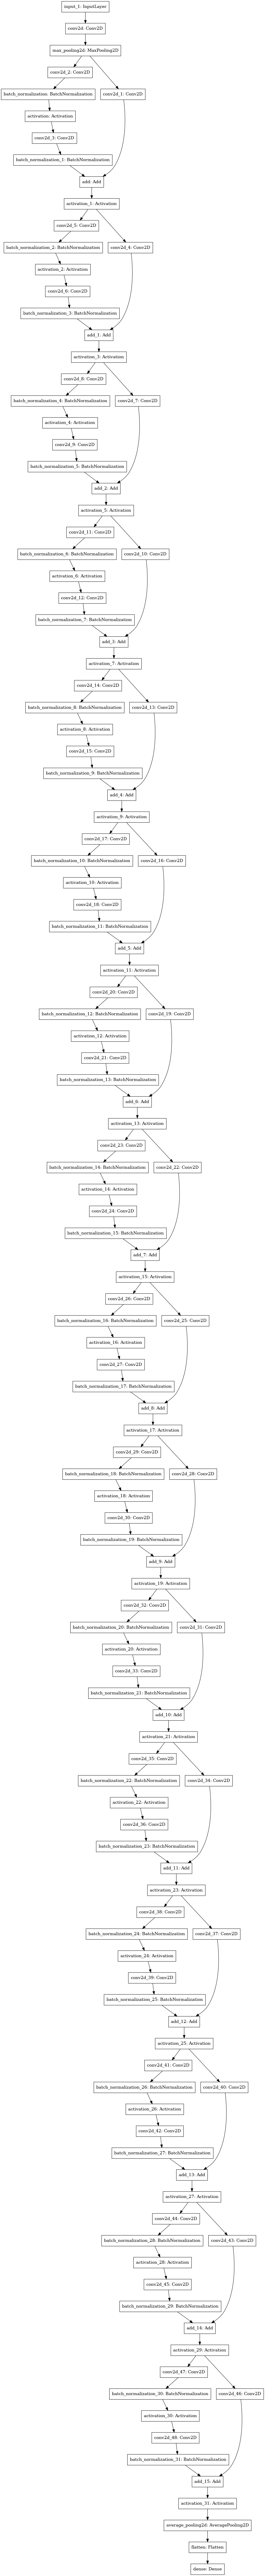

In [5]:
tf.keras.utils.plot_model(resnet_34)

In [6]:
resnet_50 = build_resnet(input_shape=(32, 32, 3), is_50=True)
resnet_50.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_49 (Conv2D)              (None, 16, 16, 64)   9472        input_2[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 8, 8, 64)     0           conv2d_49[0][0]                  
__________________________________________________________________________________________________
conv2d_51 (Conv2D)              (None, 4, 4, 64)     4160        max_pooling2d_1[0][0]            
____________________________________________________________________________________________

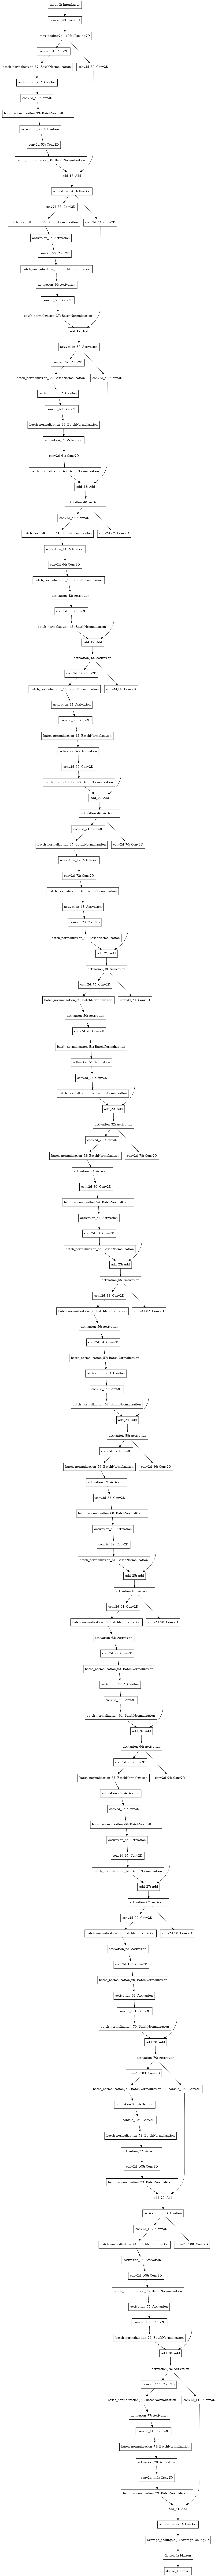

In [7]:
tf.keras.utils.plot_model(resnet_50)

# 3) 일반 네트워크(plain network) 만들기

In [8]:
plain_50 = build_resnet(input_shape=(224, 224, 3), is_50=True, use_connection=False)
plain_30 = build_resnet(input_shape=(224, 224, 3), is_50=False, use_connection=False)

In [9]:
plain_50.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv2d_114 (Conv2D)          (None, 112, 112, 64)      9472      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 56, 56, 64)        0         
_________________________________________________________________
conv2d_116 (Conv2D)          (None, 28, 28, 64)        4160      
_________________________________________________________________
batch_normalization_80 (Batc (None, 28, 28, 64)        256       
_________________________________________________________________
activation_80 (Activation)   (None, 28, 28, 64)        0         
_________________________________________________________________
conv2d_117 (Conv2D)          (None, 28, 28, 64)        3692

In [10]:
plain_30.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv2d_179 (Conv2D)          (None, 112, 112, 64)      9472      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 56, 56, 64)        0         
_________________________________________________________________
conv2d_181 (Conv2D)          (None, 28, 28, 64)        36928     
_________________________________________________________________
batch_normalization_128 (Bat (None, 28, 28, 64)        256       
_________________________________________________________________
activation_128 (Activation)  (None, 28, 28, 64)        0         
_________________________________________________________________
conv2d_182 (Conv2D)          (None, 28, 28, 64)        3692

# 4) ResNet-50 vs Plain-50 또는 ResNet-34 vs Plain-34

- 학습해보고 결과비교하기
- 224x224 픽셀 크기 데이터셋 찾기
>tensorflow-datasets에서 제공하는 cats_vs_dogs 데이터셋을 추천합니다

## 함수 불러오기

In [15]:
import tensorflow as tf
from tensorflow import keras

def residual_block(x, n_times, filters, is_50=False, use_connection=True):    
    filters_1 = filters
    filters_2 = filters * 4
    
    # 3, 4, 5번 시작할 때 Conv는 stride 2로 해줘야 됨.
    if not is_50:
        for i in range(n_times):
            shortcut = tf.keras.layers.Conv2D(filters_1, 1, 
                                              strides=2 if i==0 else 1, 
                                              activation=None, 
                                              padding='same')(x)

            x = tf.keras.layers.Conv2D(filters_1, 3, 
                                       strides=2 if i==0 else 1,
                                       activation=None, 
                                       padding='same')(x)
            
            x = tf.keras.layers.BatchNormalization()(x)
            x = tf.keras.layers.Activation("relu")(x)
            
            x = tf.keras.layers.Conv2D(filters_1, 3, activation=None, padding='same')(x)
            x = tf.keras.layers.BatchNormalization()(x)
            if use_connection:
                x = tf.keras.layers.Add()([shortcut, x])
            x = tf.keras.layers.Activation("relu")(x)
    else:
        for i in range(n_times): 
            shortcut = tf.keras.layers.Conv2D(filters_2, 1, 
                                              strides=2 if i==0 else 1, 
                                              activation=None, 
                                              padding='same')(x)
            
            x = tf.keras.layers.Conv2D(filters_1, 1, 
                                       strides=2 if i==0 else 1,
                                       activation=None, 
                                       padding='same')(x)
            
            x = tf.keras.layers.BatchNormalization()(x)
            x = tf.keras.layers.Activation("relu")(x)

            x = tf.keras.layers.Conv2D(filters_1, 3, activation=None, padding='same')(x)
            x = tf.keras.layers.BatchNormalization()(x)
            x = tf.keras.layers.Activation("relu")(x)
            
            x = tf.keras.layers.Conv2D(filters_2, 1, activation=None, padding='same')(x)
            x = tf.keras.layers.BatchNormalization()(x)
            if use_connection:
                x = tf.keras.layers.Add()([shortcut, x])
            x = tf.keras.layers.Activation("relu")(x)
            
    return x

def build_resnet(input_shape=(180, 180, 3), is_50=True, use_connection=True):
    filters = [64, 128, 256, 512]
    n_times = [3, 4, 6, 3]
    
    inputs = tf.keras.Input(input_shape)
    
    # conv1
    x = tf.keras.layers.Conv2D(64, 7, activation='relu', strides=2, padding='same')(inputs)
    
    # conv2 max pooling
    x = tf.keras.layers.MaxPool2D(3, strides=2, padding='same')(x)
    
    # Conv2 ~ Conv5    
    for i in range(4):
        x = residual_block(x, n_times[i], filters[i], is_50, use_connection)
        
    
    # average pool
    x = tf.keras.layers.AveragePooling2D(x.shape[1])(x)
    
    # fully connected
    x = tf.keras.layers.Flatten()(x)

    outputs = tf.keras.layers.Dense(10, activation='softmax')(x)
        
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    
    return model

## 데이터 준비하기
---
tfds.dataset -> 이미지에 손상이 있음 -> tfds 업데이트 하기 (4.4.0 문제 , 4.9.3 문제)  
최신버전에서는 문제가 있는 1743개를 skip해준다.  
  
---
  
-> 여전히 문제 발생   
-> 아마 tensorflow 최신 버전에서 fit 부분에 무시하는 부분을 추가해줬나보다  (2.6.0 -> 2.14.0)  
근거로 batch_size가 32일 때 colab에서는 step이 281개가 나오는 반면 여기서는 290몇개가 나왔다.  
생각해보니 step 수는 사용자가 정의해주는거니까 이건 아닌데, 어쨌든 손상된 이미지를 걸러주면 될 것 같다.

---
kaggle notebook에서도 똑같은 에러 발생 (최신버전인데도) .  
왜 colab에서만 정상 작동하는거지???


---

or colab, kaggle notebook으로 가기 or 손상된 이미지 무시하기

---

이미지 무시하는 코드를 짜는게 좀 빡세다.  
확인하려면 데이터를 불러오는 과정에서 해야하는데, ts dataset 객체를 다시 재정의해서 사용해야할 것 같다.  
이미지도 캐글에서 다운 받고

---

캐글에서 이미지 불러와서 사용하자

---

자꾸 커널이 왜 죽냐

---

데이터 수가 너무 많아서 그런 것 같다. 

---

In [12]:
# !pip install -q kaggle

In [13]:
# !kaggle competitions download -c dogs-vs-cats

In [14]:
# !unzip -qq dogs-vs-cats.zip
# !unzip -qq train.zip

In [15]:
import os

train_list = os.listdir('./data/train') 
print(train_list[:10])
print(len(train_list))

['dog.5345.jpg', 'cat.9006.jpg', 'cat.310.jpg', 'cat.7632.jpg', 'cat.9464.jpg', 'dog.5545.jpg', 'cat.11529.jpg', 'dog.10091.jpg', 'cat.6505.jpg', 'dog.11241.jpg']
25000


In [10]:
import os, shutil, pathlib

original_dir = pathlib.Path("./data/train")
new_base_dir = pathlib.Path("cats_vs_dogs_small")

# train : val = 7 : 3 
# 폴더 구분해서 생성하기

# def make_subset(subset_name, start_index, end_index):
#     for category in ("cat", "dog"):
#         dir = new_base_dir / subset_name / category
        
#         try:
#             os.makedirs(dir)
#         except:
#             1
        
#         fnames = [f"{category}.{i}.jpg"
#                   for i in range(start_index, end_index)]
#         for fname in fnames:
#             shutil.copyfile(src=original_dir / fname, 
#                             dst=dir / fname)

# make_subset("train", start_index=0, end_index=8750)
# make_subset("validation", start_index=8750, end_index=12500)

In [11]:
from tensorflow.keras.utils import image_dataset_from_directory

train_dataset = image_dataset_from_directory(
    new_base_dir / "train",
    image_size=(224, 224),
    batch_size=16)

validation_dataset = image_dataset_from_directory(
    new_base_dir / "validation",
    image_size=(224, 224),
    batch_size=16)

Found 17500 files belonging to 2 classes.
Found 7500 files belonging to 2 classes.


In [12]:
len_train = len(list(train_dataset))
len_val = len(list(validation_dataset))

print(len_train, len_val)

1094 469


In [8]:
for data_batch, labels_batch in train_dataset:
    print("data batch shape:", data_batch.shape)
    print("labels batch shape:", labels_batch.shape)
    break

data batch shape: (16, 224, 224, 3)
labels batch shape: (16,)


In [13]:
import tensorflow as tf

def normalize_and_resize_img(image, label):
    """Normalizes images: `uint8` -> `float32`."""
    return tf.cast(image, tf.float32) / 255., label

tr_ds = train_dataset.map(normalize_and_resize_img, num_parallel_calls=4)
val_ds = validation_dataset.map(normalize_and_resize_img, num_parallel_calls=4)

In [10]:
import tensorflow as tf

def normalize_and_resize_img(image, label):
    """Normalizes images: `uint8` -> `float32`."""
    return tf.cast(image, tf.float32) / 255., label

def apply_normalize_on_dataset(ds, is_test=False, batch_size=16):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=1
    )
    ds = ds.batch(batch_size)
    
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    
    return ds

train_dataset = apply_normalize_on_dataset(train_dataset)
validation_dataset = apply_normalize_on_dataset(validation_dataset, is_test=True)

In [16]:
resnet_50 = build_resnet(input_shape=(224, 224, 3), is_50=True)
resnet_30 = build_resnet(input_shape=(224, 224, 3), is_50=False)

plain_50 = build_resnet(input_shape=(224, 224, 3), is_50=True, use_connection=False)
plain_30 = build_resnet(input_shape=(224, 224, 3), is_50=False, use_connection=False)

In [ ]:
BATCH_SIZE = 16
EPOCH = 15

check_point_cb = keras.callbacks.ModelCheckpoint('data/resnet50.h5', 
                                                 save_best_only=True)

resnet_50.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01, clipnorm=1.),
    metrics=['accuracy'],
)

history_resnet_50 = resnet_50.fit(
    tr_ds,
    steps_per_epoch=len_train,
    validation_steps=len_val,
    epochs=EPOCH,
    validation_data=val_ds,
    verbose=1,
    use_multiprocessing=True,
    callbacks=[check_point_cb]
)

Epoch 1/15
1094/1094 [==============================] - ETA: 0s - loss: 0.7596 - accuracy: 0.5014

커널이 자꾸 죽어.........

## 추가로 다뤄볼만한 데이터셋들  
https://www.tensorflow.org/datasets/catalog/beans?hl=ko  
https://www.tensorflow.org/datasets/catalog/cassava?hl=ko  
https://www.tensorflow.org/datasets/catalog/stanford_dogs?hl=ko  